# Predicting House Sale Prices

In this guided project, we will work with housing data for the city of Ames, Lowa, US from 2006 to 2010. We can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), and more about the different columns [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

We will follow the pipeline of functions as the order:
- transform_features() which removes features that we don't want to use in the model, transforms text and numerical columns into proper format, and create new features by combing other features.
- select_features() which finds features that correlate strongly with our target columns.
- train_and_test() which trains linear models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold,cross_val_score

In [3]:
# read in data
data = pd.read_csv('AmesHousing.tsv',delimiter = '\t')

In [4]:
# create transform_features() and for now just returns the train data frame
def transform_features(df):
    return df

# create select_features() and for now just returns the 'Gr Liv Area' and 'SalePrice' 
# columns from the data
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

# create train_and_test() and for now perform holdout validation, and trains a model
# using all numerical columns except the 'SalePrice' column from the data frame returned from 
# select_features()
def train_and_test(df):
    # get training data and test data.
    train = df[:1460]
    test = df[1460:]
    # get features
    numeric_data = train.select_dtypes(include = np.number)
    features = numeric_data.columns.drop(['SalePrice'])
    target = 'SalePrice'
    # train a linear model
    Lr = linear_model.LinearRegression()
    Lr.fit(train[features], train[target])
    # make predictions and calculate rmse
    test_predictions = Lr.predict(test[features])
    test_mse = mean_squared_error(test_predictions, test[target]) 
    test_rmse = np.sqrt(test_mse)   
    return test_rmse

In [5]:
# test the very first model by going through the pipeline.
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)
rmse

57088.25161263909

In [6]:
# check the shape of data set at each step
print(data.shape)
print(transform_data.shape)
print(filtered_data.shape)

(2930, 82)
(2930, 82)
(2930, 2)


## Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns.

We will update transform_features() to do the following:
- remove features that we don't want to use in the model, based on the number of missing values and data leakage.
- transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values)
- create new features by combing other features.

We will first do some experiments about the process and then update the function.

In [7]:
# explore missing data
data_null = data.isnull().sum().sort_values(ascending = False)
data_null[data_null > 0]

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Electrical           1
dtype: int64

In [8]:
# columns with more than 5% missing data
data_null[data_null>0.05*len(data)]

Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Fireplace Qu     1422
Lot Frontage      490
Garage Qual       159
Garage Yr Blt     159
Garage Cond       159
Garage Finish     159
Garage Type       157
dtype: int64

In [9]:
# we will drop above columns with more than 5% missing data
data_clean = data.drop(data_null[data_null>0.05*len(data)].index,axis=1)

In [10]:
# check the difference after dropping columns
print(data.shape)
print(data_clean.shape)

(2930, 82)
(2930, 71)


In [11]:
# for the remaining columns with missing values, we will look at text columns and numerical columns respectively.
data_object_null = data_clean.select_dtypes(include= 'object').isnull().sum().sort_values(ascending = False)
print('text columns with missing values:')
print(data_object_null[data_object_null>0])
data_numeric_null = data_clean.select_dtypes(include=[np.number]).isnull().sum().sort_values(ascending = False)
print('numerical columns with missing values:')
print(data_numeric_null[data_numeric_null>0])

text columns with missing values:
Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64
numerical columns with missing values:
Mas Vnr Area      23
Bsmt Half Bath     2
Bsmt Full Bath     2
Garage Cars        1
BsmtFin SF 1       1
Total Bsmt SF      1
Bsmt Unf SF        1
BsmtFin SF 2       1
Garage Area        1
dtype: int64


In [12]:
# we will drop all text columns with missing values, and replace numerical missing values with their modes respectively.
drop_cols = data_object_null[data_object_null>0].index.tolist()
data_clean = data_clean.drop(drop_cols,axis = 1)
fill_cols = data_numeric_null[data_numeric_null>0].index.tolist()
for col in fill_cols:
    value = data_clean[col].mode()[0]
    data_clean[col] = data_clean[col].fillna(value)
print(data_clean.shape)

(2930, 64)


In [13]:
# create new feature
data_clean['Years Before Sale'] = data_clean['Yr Sold'] - data_clean['Year Built']
data_clean['Years Since Remod'] = data_clean['Yr Sold'] - data_clean['Year Remod/Add']

In [14]:
# for new features,check possible wrong data
data_clean[(data_clean['Years Before Sale'] < 0) | (data_clean['Years Since Remod'] < 0)]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years Before Sale,Years Since Remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,10,2007,New,Partial,184750,0,-1


In [15]:
# drop rows with negative values for new features
data_clean = data_clean.drop([1702, 2180, 2181], axis=0)

In [16]:
# drop original 'Year Built' and 'Year Remod/Add' columns
data_clean = data_clean.drop(["Year Built", "Year Remod/Add"], axis = 1)
## Drop columns that aren't useful for ML
data_clean= data_clean.drop(["PID", "Order"], axis=1)
## Drop columns that leak info about the final sale
data_clean = data_clean.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

In [17]:
data_clean.shape

(2927, 58)

In [18]:
# Let's summarize all above steps and update our transform_features() function.
def transform_features(df):
    # drop columns with more than 5% missing values
    df_null =  df.isnull().sum()
    df_clean = df.drop(df_null[df_null>0.05*len(df)].index,axis=1)
    # drop object columns with any missing values
    df_object_null = df_clean.select_dtypes(include= 'object').isnull().sum()
    drop_cols = df_object_null[df_object_null>0].index.tolist()
    df_clean = df_clean.drop(drop_cols,axis = 1)
    # fill in numeric columns with less than 5% missing values using the most popular value for that column
    df_numeric_null = df_clean.select_dtypes(include=[np.number]).isnull().sum()
    fill_cols = df_numeric_null[df_numeric_null>0].index.tolist()
    for col in fill_cols:
        value = df_clean[col].mode()[0]
        df_clean[col] = df_clean[col].fillna(value)
    # create new feature
    df_clean['Years Before Sale'] = df_clean['Yr Sold'] - df_clean['Year Built']
    df_clean['Years Since Remod'] = df_clean['Yr Sold'] - df_clean['Year Remod/Add']
    ### replace negative values by 0 for new features
    ### df_clean[['Years Before Sale','Years Since Remod']] = df_clean[['Years Before Sale','Years Since Remod']].replace({-1:0,-2:0})
    # drop rows with negative values for new features
    df_clean = df_clean.drop([1702, 2180, 2181], axis=0)
    # drop original columns
    df_clean = df_clean.drop(["Year Built", "Year Remod/Add"], axis = 1)
    # Drop columns that aren't useful for ML
    df_clean= df_clean.drop(["PID", "Order"], axis=1)
    # Drop columns that leak info about the final sale
    df_clean = df_clean.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df_clean

In [19]:
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)
rmse

55275.36731241307

In [20]:
print(data.shape)
print(transform_data.shape)
print(filtered_data.shape)

(2930, 82)
(2927, 58)
(2927, 2)


## Feature Selection
We will:
- Generate a correlation heatmap matrix of the numerical features in the training data set and see which features correlate strongly with the target columns.
- Explore object type data and convert certain columns to categorical data.

Again, We will first do some experiments about the process and then update the function.

In [21]:
# Let's first look at current columns
print('current numerical columns are:')
print(data_clean.select_dtypes(include=['int64','float64']).columns.tolist())
print('current text columns are:')
print(data_clean.select_dtypes('object').columns.tolist())

current numerical columns are:
['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice', 'Years Before Sale', 'Years Since Remod']
current text columns are:
['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Kitchen Qual', 'Functional', 'Paved Drive']


we notice that the "MS SubClass' column should be categorical instead of numerical.

In [22]:
# transform 'MS SubClass' to 'object' dtype
data_clean['MS SubClass'] = data_clean['MS SubClass'].astype('object')

In [23]:
print(data_clean.shape)
print(data_clean.select_dtypes('object').shape)
print(data_clean.select_dtypes(include = [np.number]).shape)

(2927, 58)
(2927, 26)
(2927, 32)


There are 26 text columns and 32 numerical columns(including the target column). For numerical columns, we will look at their correlations. And for text columns, we will look at the counts of unique values for each column.

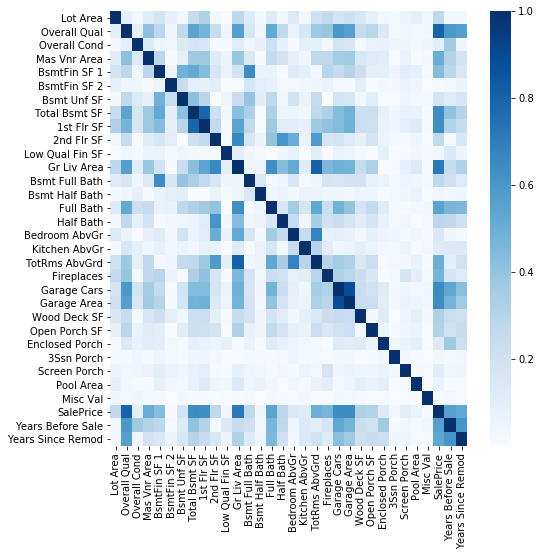

In [24]:
# generate a correlation heatmap matrix of numerical columns.
fig = plt.figure(figsize = (8,8))
sns.heatmap(data_clean.select_dtypes(include=[np.number]).corr().abs(), cmap = 'Blues')

In [25]:
# Let's look at correlation coefficients
corr_coefs = data_clean.select_dtypes(include=[np.number]).corr()['SalePrice'].abs().sort_values(ascending = False)
corr_coefs

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: SalePrice, dtype: float64

In [26]:
# Drop columns with less than 0.4 correlation with SalePrice
data_features = data_clean.drop(corr_coefs[corr_coefs < 0.4].index, axis=1)
print(data_clean.shape)
print(data_features.shape)

(2927, 58)
(2927, 40)


 next we want to dummy code certain object columns, but we don't convert columns that:
- object columns have many unique values
- object columns have a few unique values but more than 95% of the values in the column belong to a specific category.

In [27]:
# find object columns we want to convert to dummy columns
object_cols = data_features.select_dtypes('object').columns.tolist()
object_dummy_cols = []
for col in object_cols:
    total_len = len(data_features)
    col_summary = data_features[col].value_counts()
    if len(col_summary) <= 10:
        if col_summary[0] < 0.95*total_len:
            print(data_features[col].value_counts())
            object_dummy_cols.append(col)

RL         2270
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: MS Zoning, dtype: int64
Reg    1859
IR1     976
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
Lvl    2632
HLS     120
Bnk     115
Low      60
Name: Land Contour, dtype: int64
Inside     2138
Corner      510
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64
Norm      2520
Feedr      164
Artery      92
RRAn        50
PosN        38
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition 1, dtype: int64
1Fam      2422
TwnhsE     233
Duplex     109
Twnhs      101
2fmCon      62
Name: Bldg Type, dtype: int64
1Story    1480
2Story     871
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: House Style, dtype: int64
Gable      2320
Hip         549
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: Roof Style, dtype: int64
TA    1799
Gd     988
Ex     105
Fa  

In [28]:
# drop text columns that we will not convert to dummy columns
object_not_dummy_cols = list(set(object_cols) - set(object_dummy_cols))
data_features = data_features.drop(object_not_dummy_cols, axis = 1)
print(data_features.shape)

(2927, 30)


In [29]:
for col in object_dummy_cols:
    data_features[col] = data_features[col].astype('category')
    
# create dummy columns and add to the dataframe
data_features = pd.concat([
    data_features,
    pd.get_dummies(data_features[object_dummy_cols])
], axis = 1)
# drop original text columns
data_features = data_features.drop(object_dummy_cols, axis = 1)
print(data_features.shape)

(2927, 100)


In [30]:
# Let's summarize all above feature selection steps and update our select_featrues() function.
def select_features(df, coef_threshold=0.4, uniq_threshold=10):
    corr_coefs = df.select_dtypes(include=[np.number]).corr()['SalePrice'].abs()
    # Drop columns with less than "coef_threshold" correlation with SalePrice
    df = df.drop(corr_coefs[corr_coefs < coef_threshold].index, axis=1)
    # Find object columns with not too many unique values
    # and no dominant value for that column
    object_cols = df.select_dtypes('object').columns.tolist()
    object_dummy_cols = []
    for col in object_cols:
        total_len = len(df)
        col_summary = df[col].value_counts()
        if len(col_summary) <= uniq_threshold:
            if col_summary[0] < 0.95*total_len:
                object_dummy_cols.append(col)
    object_not_dummy_cols = list(set(object_cols) - set(object_dummy_cols))
    # drop columns with too many unique values or dominant value in the column
    df = df.drop(object_not_dummy_cols, axis = 1)
    # convert object columns to categorical features
    df = pd.concat([df,pd.get_dummies(df[object_dummy_cols])],axis = 1)
    # drop original object columns
    df = df.drop(object_dummy_cols, axis = 1)
    return df

In [31]:
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data)
rmse

32898.3275749655

In [32]:
print(data.shape)
print(transform_data.shape)
print(filtered_data.shape)

(2930, 82)
(2927, 58)
(2927, 100)


## Train and Test

we will update train_and_test() function to accept a parameter k that controls the type of cross validation that occurs:
- when k=0, perform holdout validation
- when k=1, perform simple cross validation
- when k>1, implement k-fold cross validation using k folds

In [33]:
def train_and_test(df, k):
    # get features and target from data
    numeric_data = df.select_dtypes(include = np.number)
    features = numeric_data.columns.drop(['SalePrice'])
    target = 'SalePrice'
    
    # when k=0 perform holdout validation
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        Lr = linear_model.LinearRegression()
        Lr.fit(train[features], train[target])
        test_predictions = Lr.predict(test[features])
        test_mse = mean_squared_error(test_predictions, test[target]) 
        test_rmse = np.sqrt(test_mse)
        
    # when k=1 perform simple cross validation    
    if k == 1:
        # 
        ## can also use shuffled_df = df.sample(frac=1, )
        new_orders = np.random.permutation(df.shape[0])
        fold_one = df.loc[new_orders[:1460]].copy()
        fold_two = df.loc[new_orders[1460:]].copy()
        
        Lr = linear_model.LinearRegression()
        Lr.fit(fold_one[features], fold_one[target])
        fold_two_predictions = Lr.predict(fold_two[features])
        fold_two_mse = mean_squared_error(fold_two_predictions, fold_two[target]) 
        fold_two_rmse = np.sqrt(fold_two_mse)
        
        Lr = linear_model.LinearRegression()
        Lr.fit(fold_two[features], fold_two[target])
        fold_one_predictions = Lr.predict(fold_one[features])
        fold_one_mse = mean_squared_error(fold_one_predictions, fold_one[target]) 
        fold_one_rmse = np.sqrt(fold_one_mse)
        
        test_rmse = average(fold_two_rmse, fold_one_rmse)
        
    
    # whe k > 1 perfome k-fold cross validation
    if k > 1:
        kf = KFold(k, shuffle = True, random_state = 1)
        Lr = linear_model.LinearRegression()
        mses = cross_val_score(Lr, df[features], df[target], scoring = 'neg_mean_squared_error', cv = kf)
        rmses = np.sqrt(np.absolute(mses))
        test_rmse = np.mean(rmses)
        
    return test_rmse

In [34]:
# when k = 0, it is just the model we got earlier, after updating select_features().
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data, k = 0)
rmse

32898.32757496559

In [35]:
# let's try k = 4, 4-fold cross validation is used.
transform_data = transform_features(data)
filtered_data = select_features(transform_data)
rmse = train_and_test(filtered_data, k = 4)
rmse

29030.02844934283

Through the pipeline, we have improved our model from a simple linear regression model (with rmse 57088) to a multiple linear regression model (with rmse 29030).